In [3]:
# load data
import numpy as np
import pandas as pd
# df = pd.read_excel('OuterHarbour-Tiel.xlsx')
# df = pd.read_excel('OuterHarbour-Tiel2.xlsx')
# df = pd.read_excel('OuterHarbour-Tiel3.xlsx')
# all_files = ['OuterHarbour-Tiel3.xlsx', 'Reims-NorthBergen.xlsx']
all_files = ['AU-NL.xlsx',]
df = pd.concat((pd.read_excel(f) for f in all_files))

In [4]:
# All nodes on the route
locs = df[["locationType", "cityName", "countryName"]].to_numpy().astype('str')
nodes = np.unique(locs, axis=0)
node_cols = [f'{node[0]}_{node[1]}_{node[2]}_visited' for node in nodes] + [f'{node[0]}_{node[1]}_{node[2]}_planned' for node in nodes]
node_df = pd.DataFrame(np.zeros((df.shape[0], len(node_cols)), dtype=np.bool8), columns=node_cols)
df.reset_index(inplace=True, drop=True)
df = pd.concat([df, node_df], axis=1)

In [5]:
df = df[df["ordSeaFreightMainTransportInvolvement"] == "J"]
df["ordJFHArrangeLoadingPickup"].fillna("", inplace=True)
df["ordJFHArrangeDelivery"].fillna("", inplace=True)
df["ordReqDeliveryDate"].fillna("", inplace=True)

In [6]:
from math import sqrt, pow

def node_name(node):
    # node = node.iloc[0]
    return f'{node["locationType"]}_{node["cityName"]}_{node["countryName"]}'

def abs_distance(o, lat, long):
    # o = origin_node.iloc[0]
    diff_lat = abs(o["latitude"] - lat) * 111.139
    diff_long =  abs(o["longitude"] - long) * 111.139
    res = sqrt(pow(diff_lat, 2) + pow(diff_long, 2))
    return res if res != 0 else 1

def dep_late(port, node_created):
    if node_created > port["actualDepDate"]:
        return "yes" if port["actualDepDate"] > port["estimatedDepDate"] else "no"
    return "unknown"
    

def get_created_date(rowNo, destination, ordCreate, reqPortL, reqPortD, origDest, locType, readyDate, actArrDate):
    if rowNo == 1:
        return ordCreate
    elif rowNo == destination["rowNo"]:
        return ordCreate
    elif origDest == "O" and locType.strip() == "P":
        return ordCreate if reqPortL else readyDate
    elif origDest == "D" and locType.strip() == "P":
        return ordCreate if reqPortD else readyDate
    return actArrDate

def get_port(port, node_created):
    return node_name(port) if node_created >= port["created"] else "unknown"

def get_progress(destination, curr_time, curr_row_no):
    if curr_row_no == destination['rowNo']:
        return 1
    elif curr_row_no == 1:
        return 0
    elif curr_time:
        return curr_time / destination["pastTimeToOrigin"]
    else:
        return pd.NaT
    
def preprocess_common(df_common):
    df_common["origin"] = [df_common.loc[(df_common["shipmentID"] == shipmentID) & (df_common["rowNo"] == 1)].iloc[0] for shipmentID in df_common["shipmentID"]]
    df_common["originCountry"] = [o["countryName"] for o in df_common["origin"]]
    df_common["pastTimeToOrigin"] = [arr_date - orig["actualDepDate"] for orig, arr_date in df_common[["origin", "actualArrDate"]].values]
    df_common["pastTimeToOrigin"] = df_common["pastTimeToOrigin"] / pd.Timedelta(hours=1)
    df_common["destination"] = [df_common.loc[(df_common["shipmentID"] == shipmentID) & (df_common["rowNo"] == df_common[df_common["shipmentID"] == shipmentID]["rowNo"].max())].iloc[0] for shipmentID in df_common["shipmentID"]]
    df_common["destinationCountry"] = [d["countryName"] for d in df_common["destination"]]
    df_common["created"] = [get_created_date(*values) for values in df_common[["rowNo", "destination", "ordaCreateDate", "prtReqPOL", "prtReqPOD", "originDestination", "locationType", "readyDate", "actualArrDate"]].values]
    df_common["created"] = df_common["created"].astype(object)
    df_common["readyDate"] = [o["readyDate"] for o in df_common["origin"]]
    df_common["consolidation"] = (df_common["ordtType"].str.strip() == "LF") | (df_common["ordtType"].str.strip() == "LFL")
    df_common["deconsolidation"] = df_common["ordtType"].str.strip() == "LFL"
    df_common["serviceType"] = [f"{'door' if p == 'Y' else 'port'}-to-{'door' if d == 'Y' else 'port'}" for p, d in df_common[["ordJFHArrangeLoadingPickup", "ordJFHArrangeDelivery"]].values]
    df_common["pastAvgAbsSpeed"] = [past_time / abs_distance(orig, lat, long) for (lat, long, orig, past_time) in df_common[["latitude", "longitude", "origin", "pastTimeToOrigin"]].values]
    df_common["counterStops"] = df_common["rowNo"] - 1
    df_common["departureOrigin"] = [o["actualDepDate"] if (i > 1 and o["actualDepDate"] > created) else None for (o, created, i) in df_common[["origin", "created", "rowNo"]].values]
    df_common["numberOfTEU"] = df_common["ordExpectedNBOfContainers"]
    df_common["totalWeight"] = df_common["ordGrossWeightKGM"]
    df_common["ETA"] = df_common["ordReqDeliveryDate"]
    df_common["ATA"] = [df_common.loc[(df_common["shipmentID"] == shipmentID) & (df_common["rowNo"] == df_common[df_common["shipmentID"] == shipmentID]["rowNo"].max())].iloc[0]["actualArrDate"] for shipmentID in df_common["shipmentID"]]
    df_common["currentMonth"] = [c.month for c in df_common["created"].values]
    df_common["portOfLoading"] = [get_port(df_common.loc[(df_common["shipmentID"] == shipmentID) & (df_common["locationType"].str.strip() == "P") & (df_common["originDestination"].str.strip() == "O")].iloc[0], created) for (shipmentID, created) in df_common[["shipmentID", "created"]].values]
    df_common["portOfDischarge"] = [get_port(df_common.loc[(df_common["shipmentID"] == shipmentID) & (df_common["locationType"].str.strip() == "P") & (df_common["originDestination"].str.strip() == "D")].iloc[0], created) for (shipmentID, created) in df_common[["shipmentID", "created"]].values]
    df_common["portDestCongestion"] = 0 # external source needed
    df_common["portOfLoadingLate"] = [dep_late(df_common.loc[(df_common["shipmentID"] == shipmentID) & (df_common["locationType"].str.strip() == "P") & (df_common["originDestination"].str.strip() == "O")].iloc[0], created) for (shipmentID, created) in df_common[["shipmentID", "created"]].values]
    df_common["progress"] = [get_progress(d, c, r) for d, c, r in df_common[["destination", "pastTimeToOrigin", "rowNo"]].values]
    df_common["origin"] = [node_name(o) for o in df_common["origin"]]
    df_common["destination"] = [node_name(d) for d in df_common["destination"]]
    return df_common.copy()

df = preprocess_common(df.copy())
# test data should only contain routes that have finished
df = df[df["ATA"].notna()]

# set visited path and future path
ss = np.unique(df["shipmentID"])
paths = [df[df["shipmentID"] == s][["locationType", "cityName", "countryName"]].apply(lambda x : node_name(x), axis=1) for s in ss]
for path, shipment in zip(paths, ss):
    for i in range(1, len(path) + 1):
        df.loc[(df["shipmentID"] == shipment) & (df["rowNo"] == i), [f"{n}_visited" for n in path[:i]]] = True
        df.loc[(df["shipmentID"] == shipment) & (df["rowNo"] == i), [f"{n}_planned" for n in path[i-1:]]] = True

    # set ETA and ATA for all shipment records and convert to time delta 
    shipment_dep_row = df.loc[(df["shipmentID"] == shipment) & (df["actualDepDate"].notnull())].iloc[0]
    shipment_arr = shipment_dep_row['ATA']
    shipment_est_arr = shipment_dep_row['ETA']
    shipment_dep = shipment_dep_row['actualDepDate']
    df.loc[df["shipmentID"] == shipment, ["ATA",]] = shipment_arr - shipment_dep
    if shipment_est_arr:
        df.loc[df["shipmentID"] == shipment, ["ETA",]] = shipment_est_arr - shipment_dep

In [7]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

df_all_columns = df.copy(deep=True)

def post_process_common(df_common):

    # convert datetime to number of days 
    df_common["departureOrigin"] = pd.to_datetime(df_common["departureOrigin"])
    df_common["departureMonthOrigin"] = df_common["departureOrigin"].apply(lambda x : x.month)
    df_common["departureDayOrigin"] = df_common["departureOrigin"].apply(lambda x : x.isoweekday())

    df_common["ETA"] = (df_common["ETA"] / pd.Timedelta(hours=1))
    for node in nodes:
        df_common[f'{node[0]}_{node[1]}_{node[2]}_visited'] = df_common[f'{node[0]}_{node[1]}_{node[2]}_visited'].astype(int)
        df_common[f'{node[0]}_{node[1]}_{node[2]}_planned'] = df_common[f'{node[0]}_{node[1]}_{node[2]}_planned'].astype(int)

    df_common = df_common.drop(columns=["progress", "departureOrigin", "estimatedDepDate", "created", "readyDate", "estimatedArrDate", "actualDepDate", "prtReqPOL", "prtReqPOD", "ordReqShipDate", "ordaCreateDate", "ordReqDeliveryDate", "latitude" , "longitude", "actualArrDate", "ordExpectedNBOfContainers", "ordGrossWeightKGM", "rowNo", "shipmentID", "originDestination", "locationType", "cityName", "countryName", "ordtType", "ordJFHArrangeLoadingPickup", "ordSeaFreightMainTransportInvolvement", "ordJFHArrangeDelivery"])
    
    return df_common.copy()
  
df = post_process_common(df.copy())
df["ATA"] = df["ATA"] / pd.Timedelta(hours=1)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

df_num = df.select_dtypes(include='number')
df_cat = df.select_dtypes(exclude='number')

y = df["ATA"]
X = df.drop(columns=["ATA"])

X_cat_cols = df_cat.columns
X_num_cols = df_num.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_num = df_num.drop(columns=["ATA"])

X_train_num, X_test_num, _, _ = train_test_split(X, y,random_state=0)

In [9]:
# drop all the columns in the dataset that have only a single value
def constant_cols(df):
    a = df.to_numpy()
    return (a[0] == a).all(0)

cols_single_value = constant_cols(df)
cols_to_drop = [column for (i, column) in enumerate(df.columns) if cols_single_value[i]]
print(f'Dropping columns {cols_to_drop} because they contain only a single value')
df = df.drop(columns=cols_to_drop)

cols_single_value = constant_cols(df_num)
cols_to_drop = [column for (i, column) in enumerate(df_num.columns) if cols_single_value[i]]
df_num = df_num.drop(columns=cols_to_drop)

cols_single_value = constant_cols(df_cat)
cols_to_drop = [column for (i, column) in enumerate(df_cat.columns) if cols_single_value[i]]
df_cat = df_cat.drop(columns=cols_to_drop)

Dropping columns ['A _Adelaide_Australia_visited', 'A _Amsterdam_Netherlands_visited', 'A _Bannockburn_Australia_visited', 'A _Basket Range_Australia_visited', 'A _Bilbul_Australia_visited', 'A _Cheltenham/Melbourne_Australia_visited', 'A _Cottesloe_Australia_visited', 'A _Gillman_Australia_visited', 'A _Langhorne Creek_Australia_visited', 'A _Lyndoch_Australia_visited', 'A _Oakbank_Australia_visited', 'A _Outer Harbor_Australia_visited', 'A _Rhoon_Netherlands_visited', 'A _Richmond_Australia_visited', 'A _Rowland Flat_Australia_visited', 'A _Sassenheim_Netherlands_visited', 'A _Schiedam_Netherlands_visited', 'A _Seppeltsfield_Australia_visited', 'A _Sevenhill_Australia_visited', 'A _Stockwell_Australia_visited', 'A _Tatachilla_Australia_visited', 'A _Trentham Cliffs_Australia_visited', 'A _Venlo_Netherlands_visited', 'A _Vijfhuizen_Netherlands_visited', 'A _Waddinxveen_Netherlands_visited', 'A _Woodcroft_Australia_visited', 'A _Zuidoostbeemster_Netherlands_visited', 'D _Port Melbourne

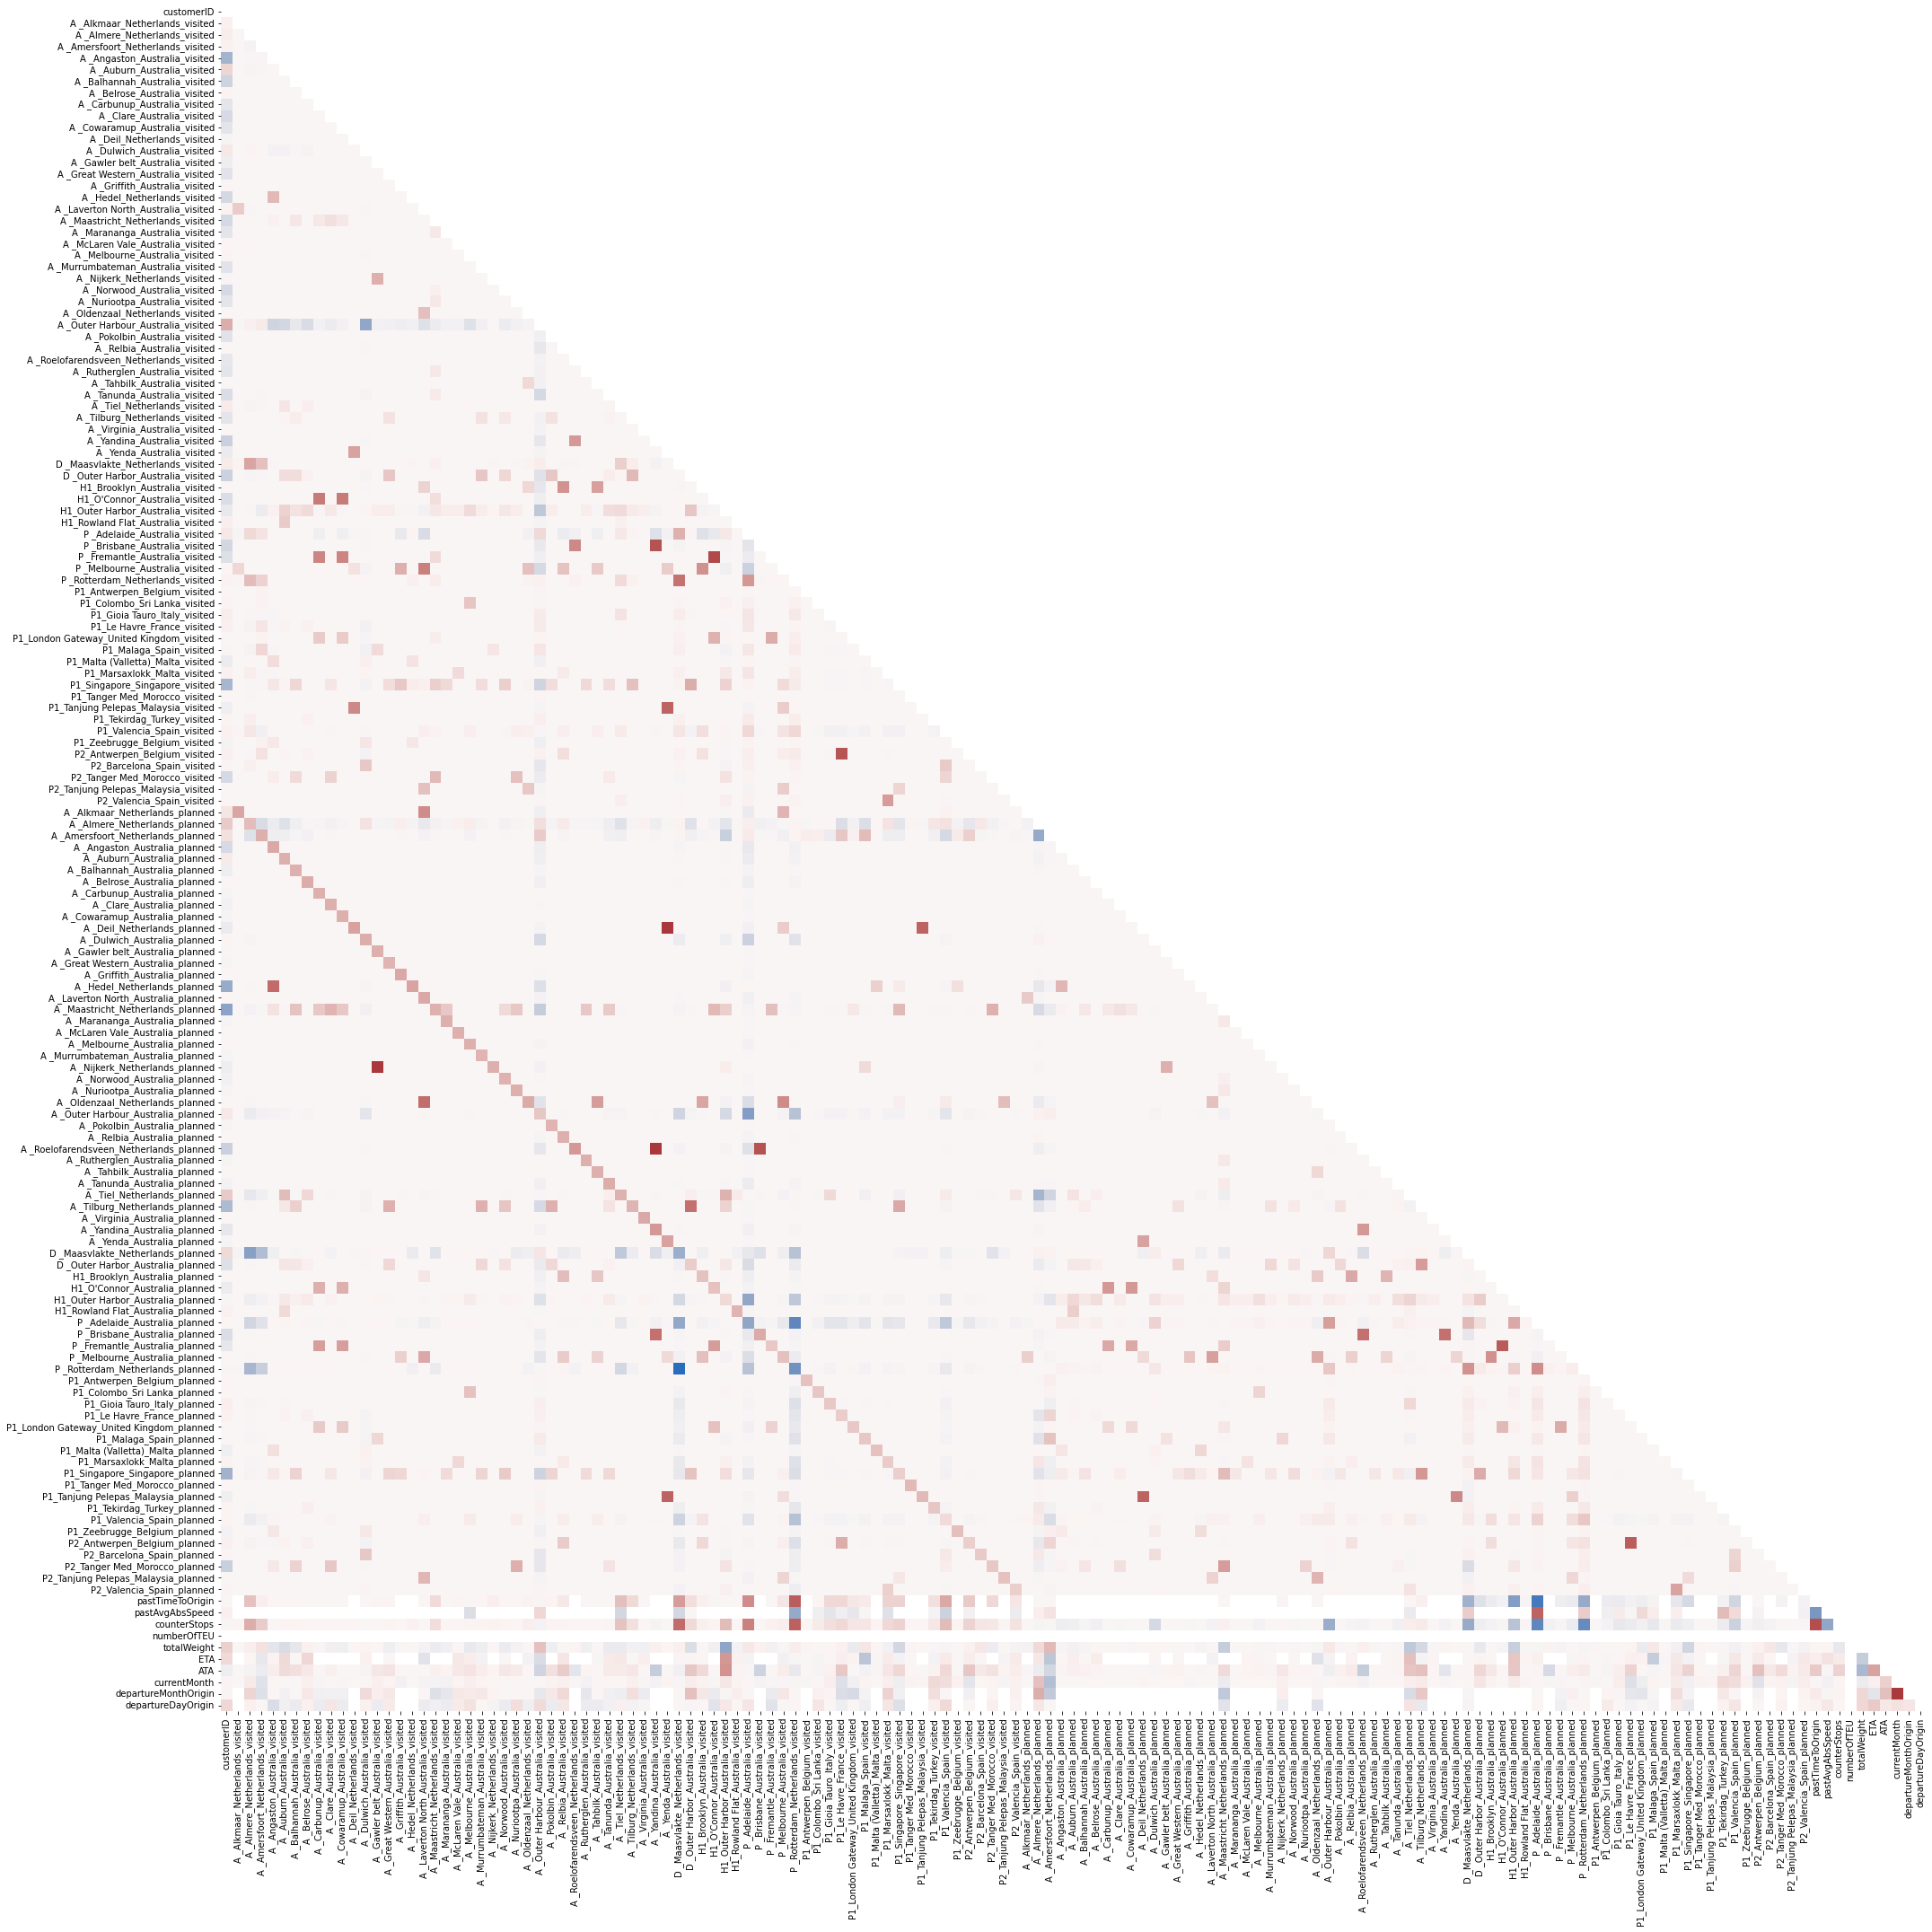

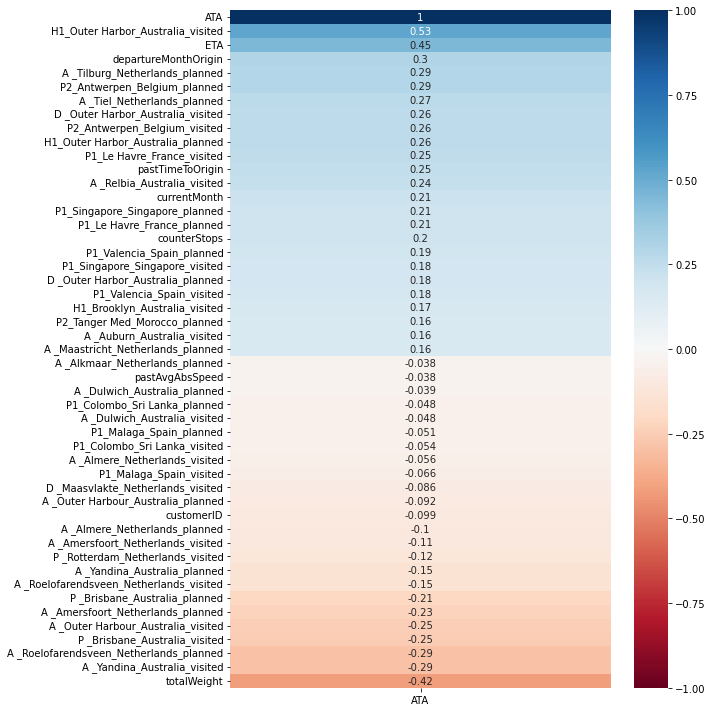

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_num.corr()

fig, axes = plt.subplots(figsize=(30,30))
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool8))
heatmap = sns.heatmap(corr_matrix, vmin=-1, mask=mask, vmax=1, annot=False, cbar=False, cmap='vlag')
fig.tight_layout()
fig.savefig('output/correlation.png')

fig, axes = plt.subplots(figsize=(10, 10))
ata_correlation = corr_matrix[['ATA']].sort_values(by='ATA', ascending=False)

ata_correlation = pd.concat([ata_correlation[:25], ata_correlation[-25:-1]])
heatmap = sns.heatmap(ata_correlation, vmin=-1, vmax=1, annot=True, cmap='RdBu')
fig.tight_layout()
fig.savefig('output/correlation_ata.png')

# sns.clustermap(corr_matrix.fillna(0), method="complete", mask=mask, cmap='RdBu', annot=False,  vmin=-1, vmax=1, figsize=(30,30))

In [11]:
from typing import List, Set

def avg(x):
    return sum(x) / len(x)

f_c_matrix = corr_matrix[["ATA"]].abs().drop('ATA')
f_f_matrix = corr_matrix.abs().drop('ATA')
feature_names_num = df_num.drop(columns=['ATA'])

def merit_S(S:Set):
    k = len(S)
    avg_f_c_corr = avg([f_c_matrix.loc[s]["ATA"] for s in S])
    scores = []
    for i in S:
        for j in S:
            scores.append(f_f_matrix[i][j])
    avg_f_f_corr = avg(scores)
    return (k * avg_f_c_corr) / sqrt((k + k * (k - 1)) * avg_f_f_corr)

def best_first_search() -> Set[str]:
    def create_single_expansion(subset) -> List[Set]:
        return [subset.union({f}) for f in feature_names_num]

    max_no_improvement = 5
    def search(subset:Set, prev_score, count_no_improvement, current_best_subset = None, current_best_score = None) -> Set[str]:
        if count_no_improvement > max_no_improvement:
            return current_best_subset
        subsets = create_single_expansion(subset)
        subsets_with_merits = [(S, merit_S(S)) for S in subsets]
        new_subset, max_score = max(subsets_with_merits, key=lambda x: x[1])

        if not current_best_score or max_score > current_best_score:
            current_best_score = max_score
            current_best_subset = new_subset

        if max_score <= prev_score:
            new_subset, max_score = max([(S, merit) for S, merit in subsets_with_merits if S != new_subset], key=lambda x: x[1])
            count_no_improvement += 1
        else:
            count_no_improvement = 0

        return search(new_subset, max_score, count_no_improvement, current_best_subset=current_best_subset)
    
    return search(set(), 0, 0)
    

cfs_result = list(best_first_search())
print(f"CFS selected the following {len(cfs_result)} numerical features out of {len(df_num)}: {cfs_result}")

CFS selected the following 15 numerical features out of 2500: ['P1_Le Havre_France_planned', 'ETA', 'A _Tilburg_Netherlands_planned', 'P2_Antwerpen_Belgium_visited', 'departureMonthOrigin', 'A _McLaren Vale_Australia_visited', 'A _Balhannah_Australia_visited', 'P1_Valencia_Spain_planned', 'pastTimeToOrigin', 'A _Tiel_Netherlands_planned', 'A _Relbia_Australia_visited', 'H1_Outer Harbor_Australia_visited', 'P2_Antwerpen_Belgium_planned', 'totalWeight', 'A _Melbourne_Australia_visited']


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = X[cfs_result + list(df_cat.columns.values)]

feature_names = X.columns
print(f'{len(feature_names)} Feature names out of {len(df)} (category and filtered numerical): {feature_names}')
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

22 Feature names out of 2500 (category and filtered numerical): Index(['P1_Le Havre_France_planned', 'ETA', 'A _Tilburg_Netherlands_planned',
       'P2_Antwerpen_Belgium_visited', 'departureMonthOrigin',
       'A _McLaren Vale_Australia_visited', 'A _Balhannah_Australia_visited',
       'P1_Valencia_Spain_planned', 'pastTimeToOrigin',
       'A _Tiel_Netherlands_planned', 'A _Relbia_Australia_visited',
       'H1_Outer Harbor_Australia_visited', 'P2_Antwerpen_Belgium_planned',
       'totalWeight', 'A _Melbourne_Australia_visited', 'origin',
       'destination', 'consolidation', 'serviceType', 'portOfLoading',
       'portOfDischarge', 'portOfLoadingLate'],
      dtype='object')


In [13]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, X_train.select_dtypes(exclude='number').columns),
        ("num", numerical_pipe, X_train.select_dtypes(include='number').columns),
    ],
    verbose_feature_names_out=False,
)
pipelines = [Pipeline(
    [
        ("preprocess", preprocessing),
        ('scaler', StandardScaler()),
        ("regressor", m),
    ]
) for m in [SVR(kernel='rbf'), SVR(kernel='linear'), RandomForestRegressor(random_state=0)]]
rf = pipelines[-1]
svr = pipelines[1]
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    print(pipe.score(X_test, y_test))

0.26216909915399356
0.5625009217026391
0.9558121767515282


Optimal number of features : 22
Optimal number of features : 22


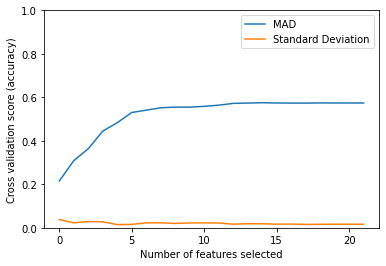

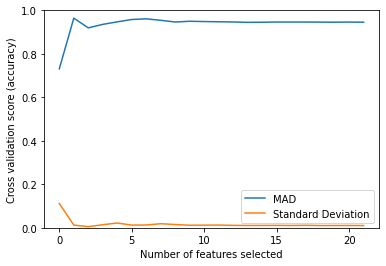

In [14]:
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

def draw(p, ext:str):
    p.fit(X_train,y_train)
    selector = p['selector']
    n_features = len(selector.cv_results_['mean_test_score'])
    print("Optimal number of features : %d" % n_features)
    plt.figure()
    plt.ylim(0,1)
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.plot(range(n_features), selector.cv_results_['mean_test_score'], label='MAD')
    plt.plot(range(n_features), selector.cv_results_['std_test_score'], label='Standard Deviation')
    plt.legend(loc="best")
    plt.savefig(f'output/rfe_{ext}.png')
# 
# SVR LINEAR
# 
svr_rfecv = Pipeline(
    [
        ("preprocess", preprocessing),
        ("scaler", StandardScaler()),
        ('selector', RFECV(svm.SVR(kernel='linear'))),
    ]
)
draw(svr_rfecv, '')
# 
# RANDOM FOREST
# 
rf_rfecv = Pipeline(
    [
        ("preprocess", preprocessing),
        ("scaler", StandardScaler()),
        ('selector', RFECV(RandomForestRegressor(random_state=0))),
    ]
)
draw(rf_rfecv, 'rf')

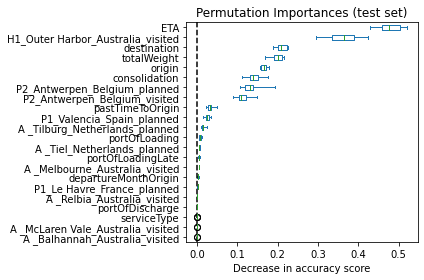

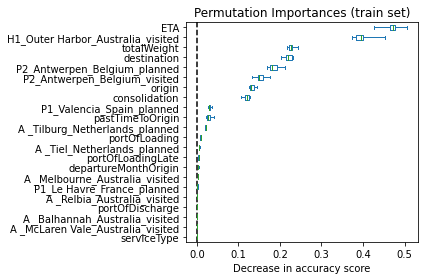

In [15]:
rf.fit(X_train, y_train)
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

plt.savefig('output/boxperms.png')

result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.savefig('output/boxperms_train.png')


c:\Users\thijn\Documents\Thesis Code\env\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


SVR()
s^2 + k^2 = 27.114, p = 1.29502e-06
z = 4.73852, p = 2.15289e-06
r2 = 0.26692, adj. r2 = 0.255801
kurtosis = 1.46019


c:\Users\thijn\Documents\Thesis Code\env\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


SVR(kernel='linear')
s^2 + k^2 = 55.8862, p = 7.31923e-13
z = 6.80576, p = 1.0052e-11
r2 = 0.561369, adj. r2 = 0.554716
kurtosis = 2.81865


c:\Users\thijn\Documents\Thesis Code\env\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


RandomForestRegressor(random_state=0)
s^2 + k^2 = 215.839, p = 1.3524e-47
z = 12.0602, p = 1.71293e-33
r2 = 0.952701, adj. r2 = 0.951984
kurtosis = 14.1488


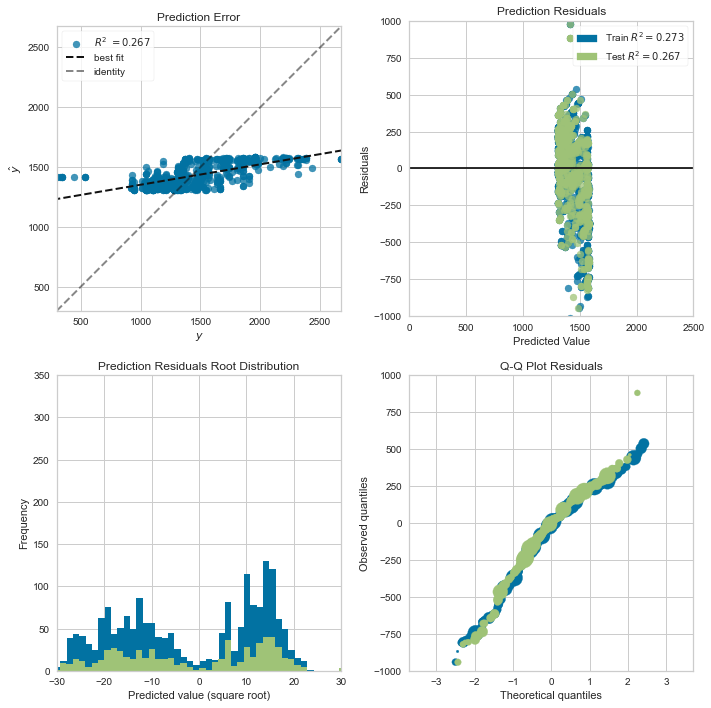

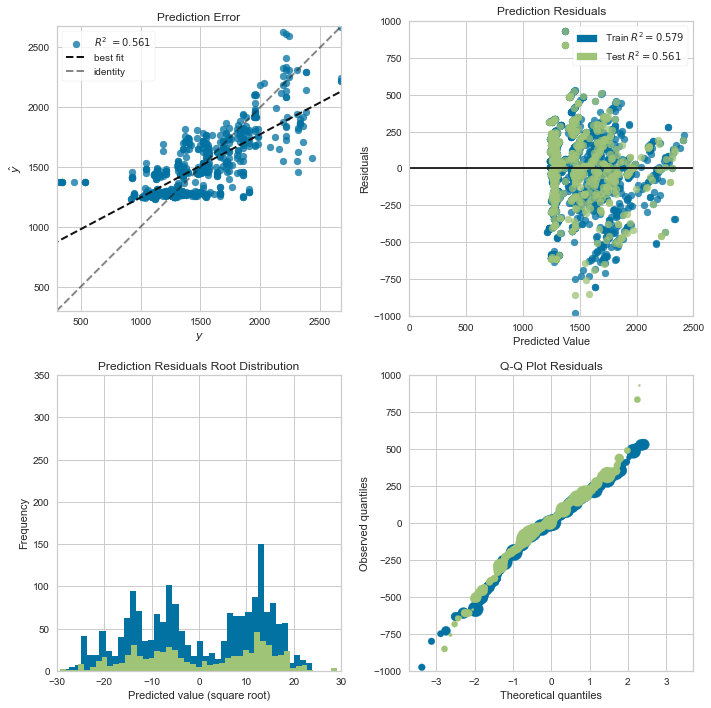

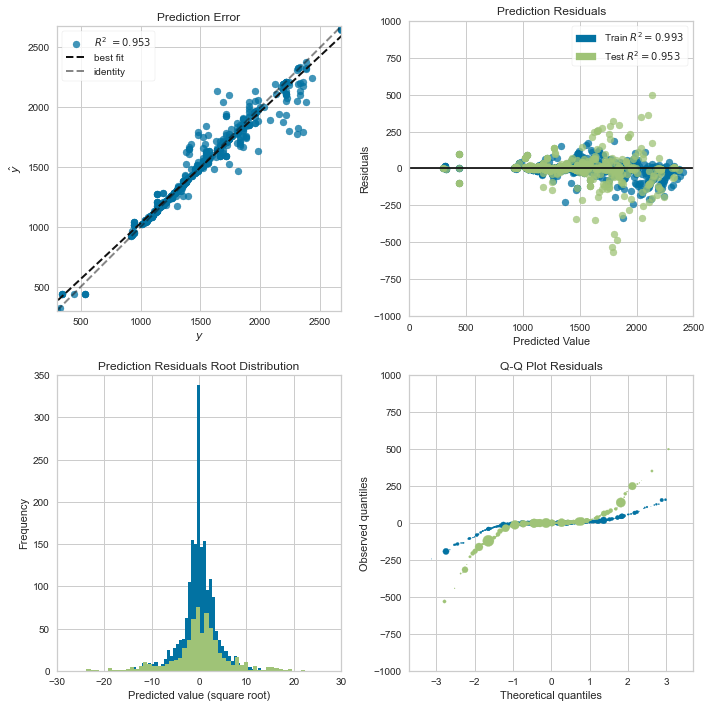

In [55]:
from yellowbrick.regressor import ResidualsPlot, PredictionError
from scipy.stats import normaltest, kurtosistest, probplot, kurtosis


for i, pipe in enumerate(pipelines):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

    visualizer = PredictionError(pipe, ax=axes[0, 0])
    visualizer.fit(X_train, y_train)
    r2 = visualizer.score(X_test, y_test)
    visualizer.finalize()
    axes[0, 0].set_title('Prediction Error')

    axes[0, 1].set_ylim((-1000, 1000))
    axes[0, 1].set_xlim((0, 2500))
    visualizer = ResidualsPlot(pipe, ax=axes[0, 1], hist=False)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.finalize()
    axes[0, 1].set_title('Prediction Residuals')

    # get residuals for test and train data
    y_pred = pipe.predict(X_train)
    residuals_train = y_pred - y_train
    y_pred = pipe.predict(X_test)
    residuals_test = y_pred - y_test

    # histograms
    axes[1, 0].set_title('Prediction Residuals Root Distribution')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_xlabel('Predicted value (square root)')
    axes[1, 0].set_xlim((-30, 30))
    axes[1, 0].set_ylim((0, 350))
    axes[1, 0].hist(np.sqrt(np.abs(residuals_train)) * np.sign(residuals_train), bins=50, label='Train')
    axes[1, 0].hist(np.sqrt(np.abs(residuals_test)) * np.sign(residuals_test), bins=50, label='Test')

    # qq plots
    osm, osr = probplot(residuals_train, dist="norm", fit=False)
    osm_test, osr_test = probplot(residuals_test, dist="norm", fit=False)
    axes[1, 1].set_title('Q-Q Plot Residuals')
    axes[1, 1].set_ylabel('Observed quantiles')
    axes[1, 1].set_xlabel('Theoretical quantiles')
    axes[1, 1].set_ylim(-1000, 1000)
    axes[1, 1].scatter(osm, osr, residuals_train, label='Train', marker='.')
    axes[1, 1].scatter(osm_test, osr_test, residuals_test, label='Test', marker='.')

    # test for normality
    print(pipe['regressor'])
    s2k2, p = normaltest(residuals_test)
    print("s^2 + k^2 = {:g}, p = {:g}".format(s2k2, p))
    z, p = kurtosistest(residuals_test)
    print("z = {:g}, p = {:g}".format(z, p))
    n = X_train.shape[0]
    p =X_train.shape[1]
    print('r2 = {:g}, adj. r2 = {:g}'.format(r2, 1-(1-r2)*(n-1)/(n-p-1)))
    print('kurtosis = {:g}'.format(kurtosis(residuals_test)))

    fig.tight_layout()

    plt.savefig(f'output/model_comparison_{pipe["regressor"]}.png')

In [17]:
df.to_excel("output/output.xlsx")

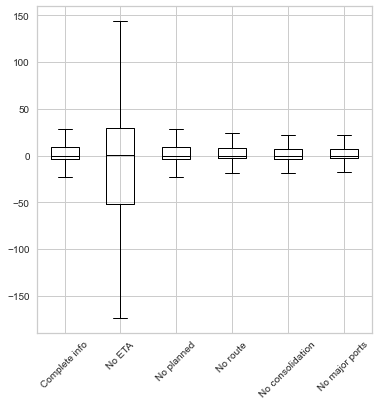

In [18]:
def get_series(xtrain, xtest, ytrain, ytest):
    # we have to rebuild the pipeline because the column list will change
    categorical_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
    )
    numerical_pipe = SimpleImputer(strategy="mean")
    preprocessing = ColumnTransformer(
        [
            ("cat", categorical_encoder, xtrain.select_dtypes(exclude='number').columns),
            ("num", numerical_pipe, xtrain.select_dtypes(include='number').columns),
        ],
        verbose_feature_names_out=False,
    )
    pipeline = Pipeline(
        [
            ("preprocess", preprocessing),
            ('scaler', StandardScaler()),
            ("regressor", RandomForestRegressor(random_state=0)),
        ]
    )
    pipeline.fit(xtrain, ytrain)
    results = pipeline.predict(xtest)
    xs = (results - ytest).to_numpy()
    xs.sort()
    return xs

def load_default():
    return (train_test_split(X, y,random_state=0))

def load_no_eta():
    X_no_eta = X.drop(columns=['ETA'])
    return (train_test_split(X_no_eta, y, random_state=0))

def load_no_planned():
    planned_columns = [c for c in X.columns.values if '_planned' in c]
    X_no_planned = X.drop(columns=planned_columns)
    return (train_test_split(X_no_planned, y, random_state=0))

def load_no_route():
    planned_columns = [c for c in X.columns.values if '_planned' in c or '_visited' in c]
    X_no_route = X.drop(columns=planned_columns)
    return (train_test_split(X_no_route, y, random_state=0))

def load_no_consolidation():
    planned_columns = [c for c in X.columns.values if c.startswith('H1_') ]
    X_no_consolidation_nodes = X.drop(columns=planned_columns)
    return (train_test_split(X_no_consolidation_nodes, y, random_state=0))

def load_no_major_ports():
    X_no_ports = X.drop(columns=['portOfLoading', 'portOfDischarge'])
    return (train_test_split(X_no_ports, y, random_state=0))

fig, axes = plt.subplots(figsize=(6,6))
series = [get_series(*f()) for f in [load_default, load_no_eta, load_no_planned, load_no_route, load_no_consolidation, load_no_major_ports]]
axes.boxplot(series, showfliers=False, medianprops={'color' : 'black'})
axes.set_xticklabels(['Complete info', 'No ETA', 'No planned', 'No route', 'No consolidation', 'No major ports'], rotation=45)
plt.savefig('output/boxplots.png')

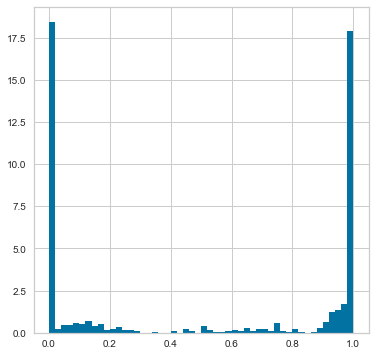

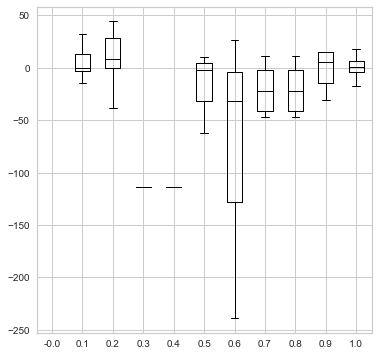

In [19]:
df_progress_X = X.copy()
df_progress_y = y.copy()
df_progress_X["progress"] = df_all_columns["progress"]
x_default_train, _, y_default_train, _ = load_default()

progress = df_progress_X[df_progress_X["progress"].notna()]["progress"].to_numpy()
fig, axes = plt.subplots(figsize=(6,6))
num_bins = 50
axes.hist(progress, bins=num_bins, label='Density histogram of progress bins', density=True)
_, x_p_test, _, y_p_test = train_test_split(df_progress_X, df_progress_y, random_state=0)
x_p_test = x_p_test[x_p_test.progress.notna()]
y_p_test = y_p_test[y_p_test.index.isin(x_p_test.index)]
progresses_x_p_test = x_p_test["progress"].to_numpy()

predictions = rf.predict(x_p_test)
residuals = predictions - y_p_test
relative_bins, bins = pd.cut(progresses_x_p_test, 10, retbins=True)
combined_vals = np.column_stack((progresses_x_p_test, predictions, residuals, relative_bins))
fig, axes = plt.subplots(figsize=(6,6))
binned_series = []
for bin in bins:
    binned_series.append([v[2] for v in combined_vals if not v[3] is np.nan and bin in v[3]])

_ = axes.boxplot(binned_series, showfliers=False, medianprops={'color' : 'black'}, labels=[round(b, 1) for b in bins])
fig.savefig('output/progressboxplots.png')

In [27]:
xtrain, xtest, ytrain, ytest = load_default()
rf.fit(xtrain, ytrain)
results = rf.predict(xtest)

def get_bin_m1(val):
    if val < 24*50:
        return 'A'
    elif val < 24*100:
        return 'B'
    else:
        return 'C'

def get_bin_m2(val):
    if val < 24*25:
        return 'A'
    elif val < 24*50:
        return 'B'
    elif val < 24*75:
        return 'C'
    elif val < 24*100:
        return 'D'
    else:
        return 'E'

def get_bin_m3(val):
    if val < 24*40:
        return 'A'
    elif val < 24*60:
        return 'B'
    elif val < 24*80:
        return 'C'
    elif val < 24*100:
        return 'D'
    else:
        return 'E'

def get_bin_m4(val):
    if val < 24*30:
        return 'A'
    elif val < 24*40:
        return 'B'
    elif val < 24*50:
        return 'C'
    elif val < 24*60:
        return 'D'
    elif val < 24*70:
        return 'E'
    elif val < 24*80:
        return 'F'
    elif val < 24*90:
        return 'G'
    elif val < 24*90:
        return 'H'
    else:
        return 'I'

print('Binning:')
for bin_method in [get_bin_m1, get_bin_m2, get_bin_m3, get_bin_m4]:
    count_correct = 0
    count_incorrect = 0

    for predicted_value, actual_value in zip(results, ytest):
        if bin_method(predicted_value) == bin_method(actual_value):
            count_correct +=1
        else:
            count_incorrect += 1

    print(count_correct / (count_correct + count_incorrect))

print('Servos:')
xs = (results - ytest).to_numpy()
xs = np.abs(xs)
xs_sq = np.square(xs)
# mae
print(sum(xs) / len(xs))
# rmse
print(np.sqrt(sum(xs_sq) / len(xs)))

print('Average / Mean duration:')
print(np.average(np.concatenate([ytest, ytrain])) / 24, np.median(np.concatenate([ytest, ytrain])) / 24)

Binning:
0.9792
0.9376
0.9408
0.88
Servos:
34.12006804395699
80.54125637025265
Average / Mean duration:
61.96672083333333 59.375
